In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
# to upload and read data in google colab
import re
import io
from google.colab import files
from google.colab import drive
# for graph
import seaborn as sns
import matplotlib.pyplot as plt
# ML preparation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
# for ML
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
#evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix

In [ ]:
uploaded = files.upload()

Saving Preprocessed_data_ID.csv to Preprocessed_data_ID.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['Preprocessed_data_ID.csv']))
df.head()

Unnamed: 0  essay_id  essay_set  \
0           0         1          1   
1           1         2          1   
2           2         3          1   
3           3         4          1   
4           4         5          1   

                                          translated  Normalised  \
0  Surat kabar lokal yang terhormat, menurut saya...         0.6   
1  Sayang, saya percaya bahwa menggunakan kompute...         0.7   
2  Sayang, Semakin banyak orang menggunakan kompu...         0.5   
3  Koran Lokal yang terhormat, Saya telah menemuk...         0.8   
4  Sayang, saya tahu memiliki komputer memiliki e...         0.6   

                                         CleanAnswer  \
0  surat kabar lokal yang terhormat menurut saya ...   
1  sayang saya percaya bahwa menggunakan komputer...   
2  sayang semakin banyak orang menggunakan komput...   
3  koran lokal yang terhormat saya telah menemuka...   
4  sayang saya tahu memiliki komputer memiliki ef...   

                                                Stem  \
0  surat kabar lokal yang hormat turut saya efek ...   
1  sayang saya percaya bahwa guna komputer akan u...   
2  sayang makin banyak orang guna komputer tetapi...   
3  koran lokal yang hormat saya telah temu bahwa ...   
4  sayang saya tahu milik komputer milik efek pos...   

                                              Tokens  char_count  word_count  \
0  ['surat', 'kabar', 'lokal', 'hormat', 'efek', ...        2064         303   
1  ['sayang', 'percaya', 'komputer', 'untung', 'b...        2539         363   
2  ['sayang', 'orang', 'komputer', 'orang', 'tuju...        3428         479   
3  ['koran', 'lokal', 'hormat', 'temu', 'ahli', '...        3243         448   
4  ['sayang', 'milik', 'komputer', 'milik', 'efek...        2766         389   

   avg_word_len  spell_err_count  
0      6.811881               17  
1      6.994490               16  
2      7.156576                8  
3      7.238839               31  
4      7.110540               16

In [ ]:
df.describe()

Unnamed: 0      essay_id     essay_set    Normalised    char_count  \
count  12949.000000  12949.000000  12949.000000  12949.000000  12949.000000   
mean    6485.924241  10291.599120      4.178083      0.589323   1366.834196   
std     3744.339811   6305.312087      2.135605      0.240037   1314.978740   
min        0.000000      1.000000      1.000000      0.000000     27.000000   
25%     3245.000000   4440.000000      2.000000      0.400000    515.000000   
50%     6487.000000  10044.000000      4.000000      0.600000    839.000000   
75%     9727.000000  15676.000000      6.000000      0.750000   1921.000000   
max    12976.000000  21633.000000      8.000000      1.000000   9857.000000   

         word_count  avg_word_len  spell_err_count  
count  12949.000000  12949.000000     12949.000000  
mean     200.540660      6.843438        11.266198  
std      194.048842      0.338905        11.117097  
min        5.000000      5.000000         0.000000  
25%       75.000000      6.632353         4.000000  
50%      122.000000      6.839416         8.000000  
75%      282.000000      7.050505        15.000000  
max     1542.000000      9.500000       163.000000

In [ ]:
# change score to 11 classes
df['Target'] = df['Normalised']*10
df['Target'] = df['Target'].round()
df['Target'] = df['Target'].astype(int)

df['Target']

0        6
1        7
2        5
3        8
4        6
        ..
12944    5
12945    4
12946    6
12947    6
12948    6
Name: Target, Length: 12949, dtype: int64

In [ ]:
text = df['Stem']
label = df['Target']

# Calculating the total vocabulary
tk = Tokenizer()
tk.fit_on_texts(text)

vocab = len(tk.word_index)+1
vocab

12883

In [ ]:
# Maximum length
max_len = np.max(df['Stem'].apply(lambda x: len(x.split())).values)
max_len

1542

In [ ]:
def embedding(text):
    return tk.texts_to_sequences(text)

train_padded = pad_sequences(embedding(text), 1542, padding='post')
train_padded

array([[  342,   488,   547, ...,     0,     0,     0],
       [  499,     3,   144, ...,     0,     0,     0],
       [  499,   317,    26, ...,     0,     0,     0],
       ...,
       [   47,     7,    90, ...,     0,     0,     0],
       [12878,     4,  1528, ...,     0,     0,     0],
       [   26,     8,   144, ...,     0,     0,     0]], dtype=int32)

In [ ]:
categories=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
def seaborn_conf(y, ypred):
    y_true = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    y_pred = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    # make sure both arrays are of the same type
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)
    cf = confusion_matrix(y, ypred)
    df_cm = pd.DataFrame(cf, columns=np.unique(y_true), index = np.unique(y_true))
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted value')
    plt.ylabel('Real value')
    plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_padded, label, test_size=0.2)

In [ ]:
#start ML
#naive bayes
nb = MultinomialNB()

# Train the model - CountVectorizer model
nb.fit(x_train, y_train)

MultinomialNB()

In [ ]:
# Class and probability predictions
yp_class = nb.predict(x_test)
yp_prob = nb.predict_proba(x_test)[:, 1]

0.17065637065637065


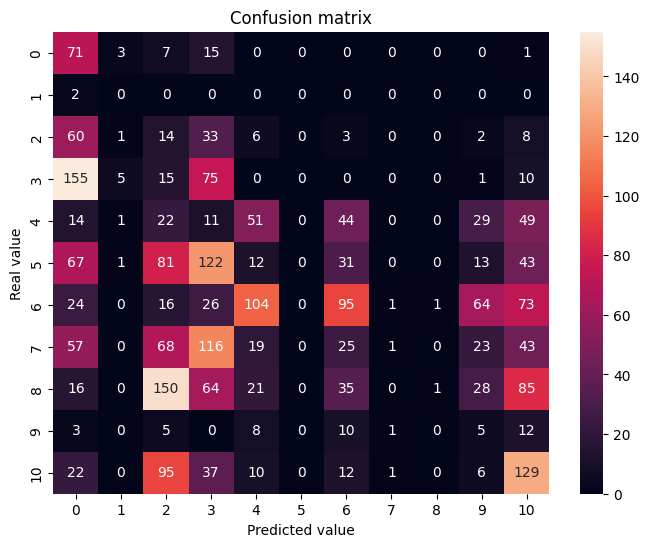

In [ ]:
print(metrics.accuracy_score(y_test, yp_class))
seaborn_conf(y_test, yp_class)

In [ ]:
# xgb
n_est = np.arange(50, 400, 50)
test_XG = []
for nest in n_est:
    xgb_classifier = xgb.XGBClassifier(n_estimators = nest,
                                       learning_rate=0.15,
                                       max_depth=7,
                                       use_label_encoder=False,
                                       eval_metric='auc')
    xgb_classifier.fit(x_train, y_train)
    yp = xgb_classifier.score(x_test, y_test)
    test_XG.append(yp)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarnin

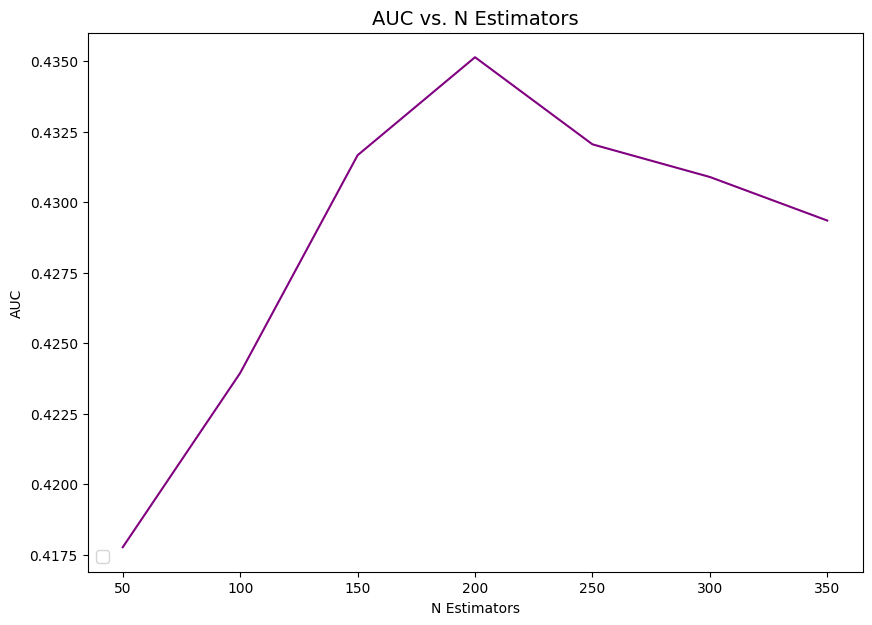

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(n_est, test_XG, c='purple')
plt.xlabel('N Estimators')
plt.xticks(n_est)
plt.ylabel('AUC')
plt.legend(prop={'size': 12}, loc=3)
plt.title('AUC vs. N Estimators', size=14)
plt.show()

In [ ]:
xgb_classifier = xgb.XGBClassifier(n_estimators = 200,
                                       learning_rate=0.15,
                                       max_depth=7,
                                       use_label_encoder=False)
xgb_classifier.fit(x_train, y_train)
yp = xgb_classifier.predict(x_test)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0.43513513513513513


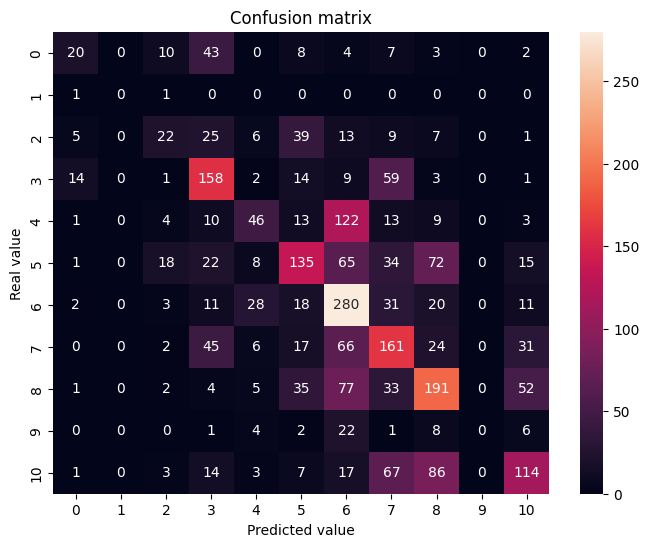

In [ ]:
print(metrics.accuracy_score(y_test, yp))
seaborn_conf(y_test, yp)